<a href="https://colab.research.google.com/github/MinaSGorgy/HelpNavigateRobots/blob/master/HelpNavigateRobots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement

Robots are smart… by design. To fully understand and properly navigate a task, however, they need input about their environment.

In this competition, you’ll help robots recognize the floor surface they’re standing on using data collected from Inertial Measurement Units (IMU sensors).

We’ve collected IMU sensor data while driving a small mobile robot over different floor surfaces on the university premises. The task is to predict which one of the nine floor types (carpet, tiles, concrete) the robot is on using sensor data such as acceleration and velocity. Succeed and you'll help improve the navigation of robots without assistance across many different surfaces, so they won’t fall down on the job.

# Data Description

- **X_[train/test].csv** - the input data, covering 10 sensor channels and 128 measurements per time series plus three ID columns:

  - row_id: The ID for this row.

  - series_id: ID number for the measurement series. Foreign key to y_train/sample_submission.

  - measurement_number: Measurement number within the series.

The orientation channels encode the current angles how the robot is oriented as a quaternion (see Wikipedia). Angular velocity describes the angle and speed of motion, and linear acceleration components describe how the speed is changing at different times. The 10 sensor channels are:

    - orientation_X

    - orientation_Y

    - orientation_Z

    - orientation_W

    - angular_velocity_X

    - angular_velocity_Y

    - angular_velocity_Z

    - linear_acceleration_X

    - linear_acceleration_Y

    - linear_acceleration_Z

- **y_train.csv** - the surfaces for training set.

  - series_id: ID number for the measurement series.

  - group_id: ID number for all of the measurements taken in a recording session. Provided for the training set only, to enable more cross validation strategies.

  - surface: the target for this competition.

- **sample_submission.csv** - - a sample submission file in the correct format.

In [0]:
# Download Dataset
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"minasgorgi","key":"0de353e217e2dca3e5c61e530055c2d8"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c career-con-2019

502 - Bad Gateway


In [0]:
# Unpack data
!unzip X_train.csv.zip
!unzip X_test.csv.zip

In [4]:
# Load Data
import pandas as pd

x_train = pd.read_csv('data/X_train.csv')
y_train = pd.read_csv('data/y_train.csv')
x_test = pd.read_csv('data/X_test.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

In [5]:
# Inspect Data
x_train.tail()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
487675,3809_123,3809,123,0.62871,-0.76878,-0.084391,0.081093,0.003167,0.093760,-0.14274,3.27180,2.0115,-9.0063
487676,3809_124,3809,124,0.62884,-0.76868,-0.084365,0.081099,0.014994,0.032637,-0.13238,4.42750,3.0696,-8.1257
487677,3809_125,3809,125,0.62891,-0.76861,-0.084345,0.081178,-0.031184,-0.003961,-0.13894,2.70480,4.2622,-8.1443
487678,3809_126,3809,126,0.62903,-0.76850,-0.084414,0.081231,-0.069153,0.013229,-0.13021,2.54100,4.7130,-9.4435
487679,3809_127,3809,127,0.62915,-0.76839,-0.084441,0.081284,-0.042769,0.034049,-0.12580,0.82391,4.2751,-10.4980


In [79]:
import matplotlib
import numpy as np
from matplotlib import pyplot as plt

x_train_concrete.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
128,1_0,1,0,-0.95896,0.24074,0.030758,-0.14661,0.283420,0.002192,-0.050810,2.18480,2.25260,-8.9503
129,1_1,1,1,-0.95890,0.24079,0.030786,-0.14693,0.108930,-0.009485,0.009155,0.49905,2.97620,-5.4953
130,1_2,1,2,-0.95889,0.24076,0.030807,-0.14702,-0.073197,0.003959,-0.023384,0.74827,1.68030,-7.3061
131,1_3,1,3,-0.95888,0.24076,0.030742,-0.14712,-0.064979,0.068265,0.018673,1.84080,0.22349,-11.4910
132,1_4,1,4,-0.95888,0.24079,0.030707,-0.14702,0.077929,0.005519,0.022119,-0.49667,-0.92942,-12.2980


In [84]:
x_train_concrete.series_id.unique()[:5]

array([ 1,  2,  3,  7, 14])

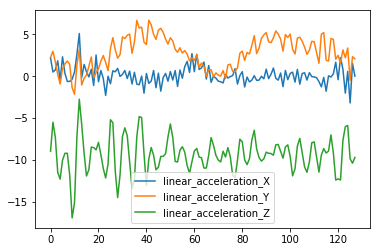

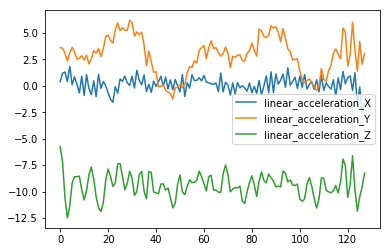

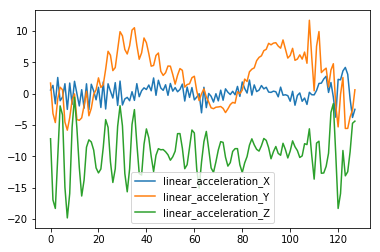

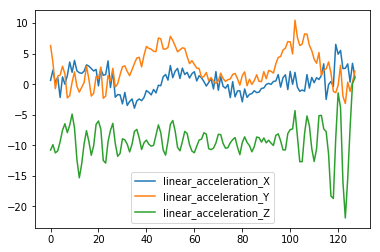

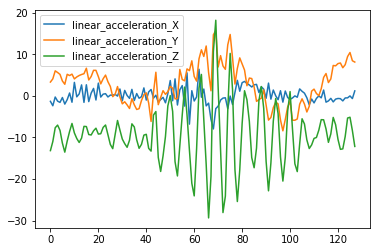

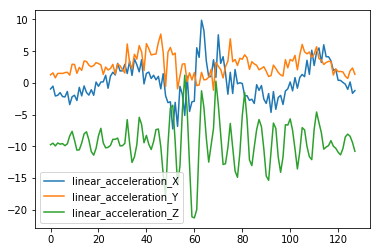

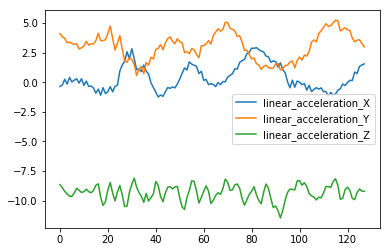

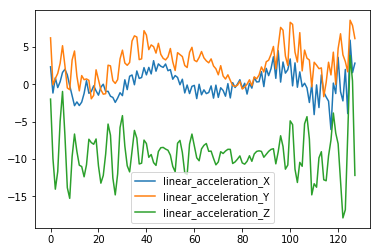

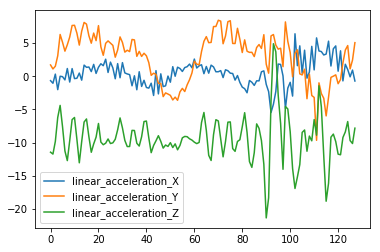

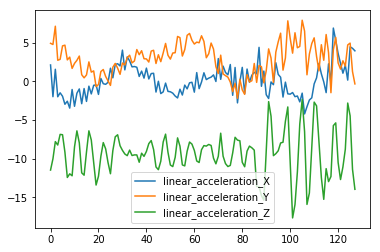

In [91]:
for series_id in x_train_concrete.series_id.unique()[:10]:
    x_train_concrete_series = x_train_concrete[x_train_concrete.series_id == series_id]
    for i in range(10,13):
        plt.plot(x_train_concrete_series.measurement_number,x_train_concrete_series.iloc[:,i])
    plt.legend()
    plt.show()

In [129]:
from scipy.spatial.transform import Rotation as R
rotation_angles = R.from_quat(np.transpose([x_train_concrete.orientation_X,x_train_concrete.orientation_Y,x_train_concrete.orientation_Z,x_train_concrete.orientation_W]))
euler_rotation_angles = rotation_angles.as_euler('xyz',degrees=True)
euler_rotation_angles = np.transpose(euler_rotation_angles)
angles_frame = pd.DataFrame( {'row_id':x_train_concrete.row_id,
                            'series_id':x_train_concrete.series_id,
                            'measurement_number': x_train_concrete.measurement_number,
                            'orientation_x':euler_rotation_angles[0] - np.mean(euler_rotation_angles[0]),
                            'orientation_y':euler_rotation_angles[1] - np.mean(euler_rotation_angles[1]),
                            'orientation_z':euler_rotation_angles[2] - np.mean(euler_rotation_angles[2])})

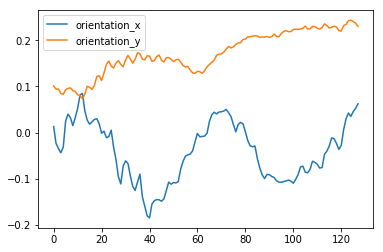

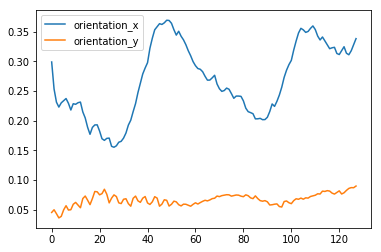

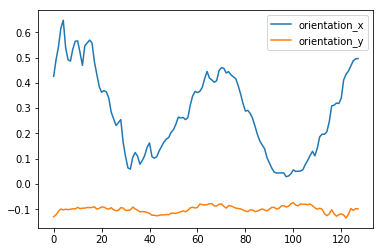

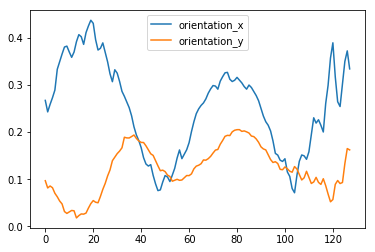

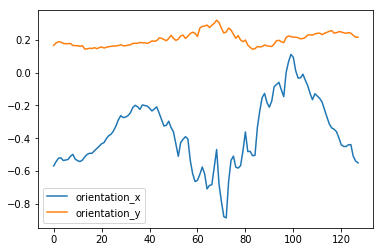

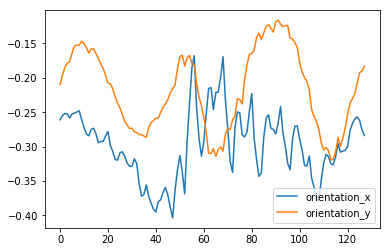

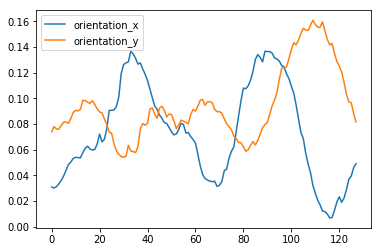

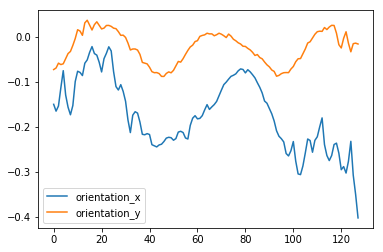

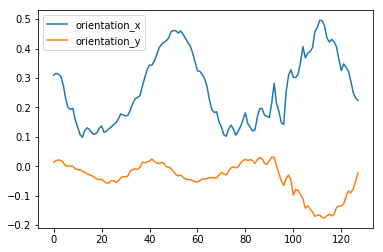

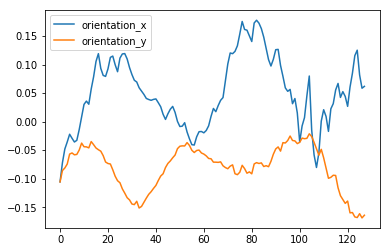

In [131]:
for series_id in angles_frame.series_id.unique()[:10]:
    x_train_concrete_series = angles_frame[angles_frame.series_id == series_id]
    for i in range(3,5):
        plt.plot(x_train_concrete_series.measurement_number,x_train_concrete_series.iloc[:,i])
    plt.legend()
    plt.show()

In [142]:
def get_data_surface_type(surface_type):
    x_train_surface = x_train[np.isin(x_train.series_id.values,
                                       y_train[y_train.surface==surface_type].series_id.values)]
    rotation_angles = R.from_quat(np.transpose([x_train_surface.orientation_X,x_train_surface.orientation_Y,x_train_surface.orientation_Z,x_train_surface.orientation_W]))
    euler_rotation_angles = rotation_angles.as_euler('xyz',degrees=True)
    euler_rotation_angles = np.transpose(euler_rotation_angles)
    angles_frame = pd.DataFrame( {'row_id':x_train_surface.row_id,
                                    'series_id':x_train_surface.series_id,
                                    'measurement_number': x_train_surface.measurement_number,
                                    'orientation_x':euler_rotation_angles[0] - np.mean(euler_rotation_angles[0]),
                                    'orientation_y':euler_rotation_angles[1] - np.mean(euler_rotation_angles[1]),
                                    'orientation_z':euler_rotation_angles[2] - np.mean(euler_rotation_angles[2]),
                                    'angular_velocity_x':x_train_surface.angular_velocity_X,
                                    'angular_velocity_y':x_train_surface.angular_velocity_Y,
                                    'angular_velocity_z':x_train_surface.angular_velocity_Z,
                                    'linear_acceleration_x':x_train_surface.linear_acceleration_X,
                                    'linear_acceleration_y':x_train_surface.linear_acceleration_Y,
                                    'linear_acceleration_y':x_train_surface.linear_acceleration_Z})
    return angles_frame
frame = get_data_surface_type('concrete')

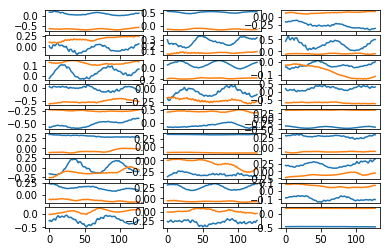

In [155]:
def plot_data(data_frame,plotting_axes,row_idx):
    col_idx = 0
    for series_id in data_frame.series_id.unique()[:3]:
        x_train_series = data_frame[data_frame.series_id == series_id]
        for i in range(3,5):
            plotting_axes[row_idx,col_idx].plot(x_train_series.measurement_number,x_train_series.iloc[:,i])
        col_idx +=1
figure,axes = plt.subplots(9,3)
row_idx = 0
for surface_type in y_train.surface.unique():
    #print(surface_type)
    frame = get_data_surface_type(surface_type)
    plot_data(frame,axes,row_idx)
    row_idx+=1
figure
figure.show()

In [6]:
sample_submission.tail()

,series_id,surface
0,0,concrete
1,1,concrete
2,2,concrete
3,3,concrete
4,4,concrete


In [72]:
y_train.head()

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles
